# FIFA20 Analysis and Modelling

In this capstone project, I will explore the soccer player's best position and overall rating based on the different attributes. FIFA20 is a video game that is designed by the data collected from the real world, so it can be a good source to analyze data and build up the predictive model.

In the beginning, I need to import some basic and essential packages:

In [1]:
# Baisc packages installed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import joblib
import warnings
warnings.filterwarnings("ignore")

## Data Cleaning

Use the pandas to read in the original CSV file and check the shape of original data frame:

In [2]:
# Load the original data
original_df = pd.read_csv('data/players_20.csv')
print('The shape of the original Dataframe is : ', original_df.shape)

The shape of the original Dataframe is :  (18278, 104)


Because this is an uncleaned data frame, I define a function to display how many null values we have in each column:

In [3]:
# Function to chekc NA value
def display_NA_counts(the_df):
    null_series = the_df.isna().sum(axis = 0)
    display(null_series[null_series > 0])
display_NA_counts(original_df)

release_clause_eur       1298
player_tags             16779
team_position             240
team_jersey_number        240
loaned_from             17230
joined                   1288
contract_valid_until      240
nation_position         17152
nation_jersey_number    17152
pace                     2036
shooting                 2036
passing                  2036
dribbling                2036
defending                2036
physic                   2036
gk_diving               16242
gk_handling             16242
gk_kicking              16242
gk_reflexes             16242
gk_speed                16242
gk_positioning          16242
player_traits           10712
ls                       2036
st                       2036
rs                       2036
lw                       2036
lf                       2036
cf                       2036
rf                       2036
rw                       2036
lam                      2036
cam                      2036
ram                      2036
lm        

As we can see, there is a huge difference in attributes between goalkeepers and other players. The goalkeepers just have the specific goal keeper's attributes. In other words, other players have all kinds of attributes except the goalkeeper's specific attributes. Thus, I decided to assume that those null values will be 0. Besides that, I also drop some duplicated and useless features. In the next step, I assume that the first option of position is the player's best position. Finally, I run the null value checking function again to make sure that the data is cleaned:

In [4]:
# Make a copy of original data frame
df = original_df.copy()

# Drop some duplicated and useless columns
df.drop(columns = ['player_tags','loaned_from','nation_position','nation_jersey_number',\
                   'player_traits','sofifa_id','player_url','long_name','dob','ls','st',\
                   'rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm',\
                   'rm','lwb','ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb','preferred_foot',\
                   'work_rate','body_type','real_face','team_jersey_number','joined',\
                   'release_clause_eur','contract_valid_until','team_position'], 
        inplace = True)

# Fill in the null value of attributes with 0
df.fillna(value = {'gk_diving':0,'gk_handling':0,'gk_kicking':0,'gk_reflexes':0,\
                   'gk_speed':0,'gk_positioning':0,'pace':0,'shooting':0,'passing':0,\
                   'dribbling':0, 'defending':0, 'physic':0}, inplace = True)

# change the data type of numeric features to int64
df = df.astype({'pace': 'int64','shooting': 'int64','passing': 'int64','dribbling': 'int64',\
                'defending': 'int64','physic': 'int64','gk_diving': 'int64','gk_handling': 'int64',\
                'gk_kicking': 'int64','gk_reflexes': 'int64','gk_speed': 'int64','gk_positioning': 'int64'})

# Assume the first option is the player's best position
df['best_pos'] = df['player_positions'].str.split(',').str[0]
dict_pos={'ST':'Fwd_Center',
          'CF':'Fwd_Center',
          'LW':'Side_Winger',
          'RW':'Side_Winger',
          'LM':'Mid_Side',
          'RM':'Mid_Side',
          'CM':'Mid_Center',
          'CAM':'Mid_Center',
          'CDM':'Mid_Center',
          'CB':'Back_Center',
          'LB':'Back_Side',
          'RB':'Back_Side',
          'LWB':'Back_Side',
          'RWB':'Back_Side',
          'GK':'Goal_keeper'}
df['best_pos']=df['best_pos'].map(dict_pos)
df.drop(columns = ['player_positions'], inplace = True)

# Double the data set
display_NA_counts(df)

Series([], dtype: int64)

Also, I print out the shape and column information of the cleaned data set:

In [5]:
print('The shape of the cleaned Dataframe is : ', df.shape, '\n')
df.info()

The shape of the cleaned Dataframe is :  (18278, 60) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18278 entries, 0 to 18277
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   short_name                  18278 non-null  object
 1   age                         18278 non-null  int64 
 2   height_cm                   18278 non-null  int64 
 3   weight_kg                   18278 non-null  int64 
 4   nationality                 18278 non-null  object
 5   club                        18278 non-null  object
 6   overall                     18278 non-null  int64 
 7   potential                   18278 non-null  int64 
 8   value_eur                   18278 non-null  int64 
 9   wage_eur                    18278 non-null  int64 
 10  international_reputation    18278 non-null  int64 
 11  weak_foot                   18278 non-null  int64 
 12  skill_moves                 18278 non-null  int

## Data Visualization

To get better insights and be familiar with the relationship between features and targets, I start the analysis by displaying some visualizations at the beginning. Firstly, I design a function to display Top 10 clubs and nationalities that have the highest overall rating:

In [6]:
# Function to show the Top 10 clubs and nationalities
def top_n_charts(field,n,data):
    
    # Process the data for visualizing
    sub_df = data[['short_name',field,'overall']]
    sub_df['count'] = 1
    sub_df = sub_df.groupby(field).sum()
    # Club option
    if field == 'club':
        sub_df = sub_df[sub_df['count'] > 25]
    # Nationality option
    elif field == 'nationality':
        sub_df = sub_df[sub_df['count'] > 200]
    sub_df['overall_mean'] = (sub_df['overall']/sub_df['count'])
    sub_df = sub_df.sort_values('overall_mean',ascending = False).reset_index()
    sub_df = sub_df.iloc[:n,:]
    sub_df['overall_mean'] = round(sub_df['overall_mean'], 2)
    
    # Figure plotting
    fig = plt.figure(figsize = (20,7))
    ax = sns.barplot(x = field, y = 'overall_mean', data = sub_df, color='lightsalmon')
    
    # Figure label setting
    plt.xlabel(f'{field}', size = 15)
    plt.ylabel('Average Overall Score', size = 15)
    plt.title(f'Top 10 {field} with Highest Scores', size=20)
    plt.tick_params(axis = 'x', labelsize = 12)
    plt.tick_params(axis = 'y', labelsize = 15)
    plt.xticks(rotation=15)
    y_min = int(sub_df['overall_mean'].min())-2
    y_max = int(sub_df['overall_mean'].max())+2
    plt.ylim((y_min, y_max))
    
    # Display the values on th graphs
    display(sub_df)
    for index, row in sub_df.iterrows():
        ax.text(x=index, y=row.overall_mean, s=str(row.overall_mean), c='black', ha='center', va='bottom', fontsize=16)
    plt.show()

,club,overall,count,overall_mean
0,Real Madrid,2644,33,80.12
1,Juventus,2642,33,80.06
2,FC Barcelona,2586,33,78.36
3,Chelsea,2543,33,77.06
4,Manchester City,2541,33,77.00
5,Napoli,2383,31,76.87
6,Manchester United,2536,33,76.85
7,Tottenham Hotspur,2524,33,76.48
8,Atlético Madrid,2514,33,76.18
9,Milan,2209,29,76.17


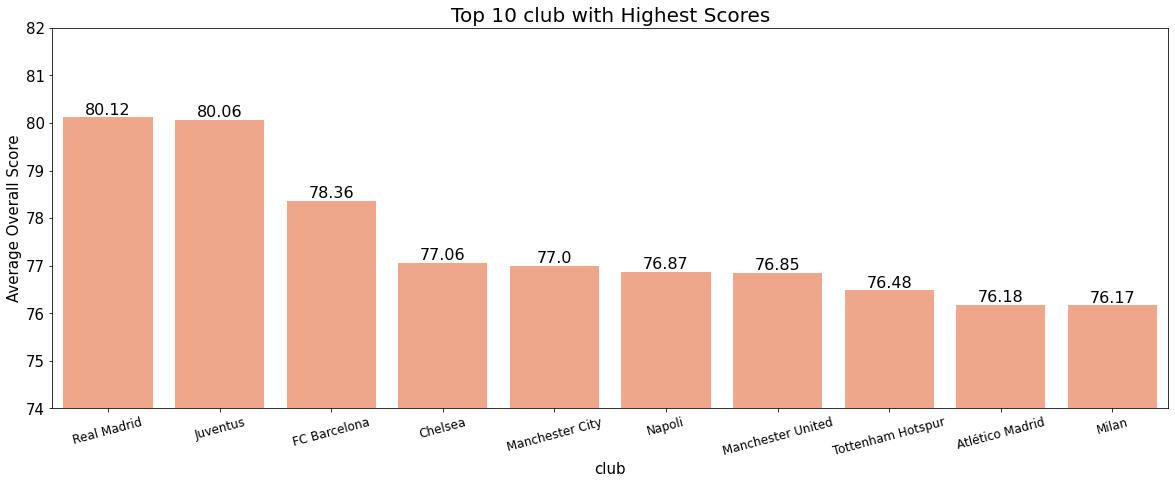

In [7]:
# Top 10 clubs
top_n_charts('club',10,df)

,nationality,overall,count,overall_mean
0,Brazil,58637,824,71.16
1,Portugal,24257,344,70.51
2,Spain,72402,1035,69.95
3,Argentina,61239,886,69.12
4,Belgium,18340,268,68.43
5,Netherlands,28350,416,68.15
6,Italy,49525,732,67.66
7,France,66338,984,67.42
8,Turkey,19424,294,66.07
9,Germany,80182,1216,65.94


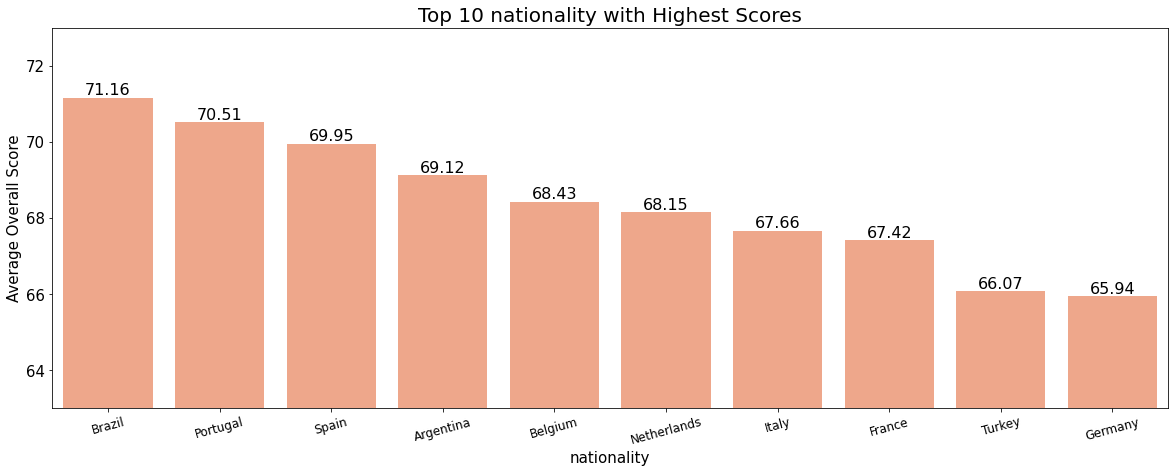

In [8]:
# Top 10 natinalities
top_n_charts('nationality',10,df)

After that, I also want to see if there has any diffence in player's value and wage based on the different position they played:

,best_pos,value_eur
0,Side_Winger,4.111091
1,Fwd_Center,2.902221
2,Mid_Center,2.838884
3,Mid_Side,2.398313
4,Back_Center,2.350177
5,Back_Side,1.803172
6,Goal_keeper,1.728016


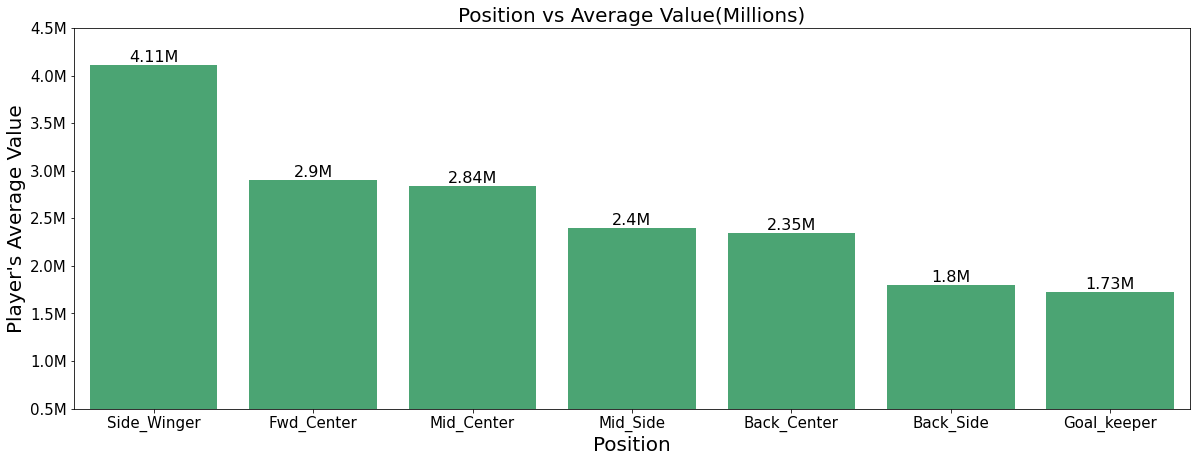

In [9]:
# make a copy and preprocess the data
pos_value_df = df.copy()
pos_value_df = pos_value_df.groupby(['best_pos'])\
                           .mean()\
                           .reset_index()\
                           .sort_values\
                           ('value_eur', ascending = False)[['best_pos','value_eur']]
pos_value_df['value_eur'] = pos_value_df['value_eur']/(10**6)
pos_value_df.reset_index(inplace = True, drop = True)

# Figure plotting
fig = plt.figure(figsize = (20,7))
ax = sns.barplot(x = 'best_pos', y = 'value_eur', data = pos_value_df, color = 'mediumseagreen')
ax.set_yticklabels(labels = ['0.5M','1.0M','1.5M','2.0M','2.5M','3.0M','3.5M','4.0M','4.5M'])

# Set the preference of label
plt.xlabel('Position', size = 20)
plt.ylabel("Player's Average Value", size = 20)
plt.title(f'Position vs Average Value(Millions)', size=20)    
plt.tick_params(axis = 'x', labelsize = 15)
plt.tick_params(axis = 'y', labelsize = 15)    
y_min = int(pos_value_df['value_eur'].min())-0.5
y_max = int(pos_value_df['value_eur'].max())+0.5
plt.ylim((y_min, y_max))
    
# Display the value on the graph
display(pos_value_df)
for index, row in pos_value_df.iterrows():
    ax.text(x=index, y=row.value_eur, s=str(round(row.value_eur,2))+'M', c='black', ha='center', va='bottom', fontsize=16)
plt.show()

,best_pos,wage_eur
0,Side_Winger,14.931727
1,Fwd_Center,10.928015
2,Mid_Center,10.150535
3,Back_Center,9.293801
4,Mid_Side,8.524535
5,Back_Side,8.301873
6,Goal_keeper,6.667976


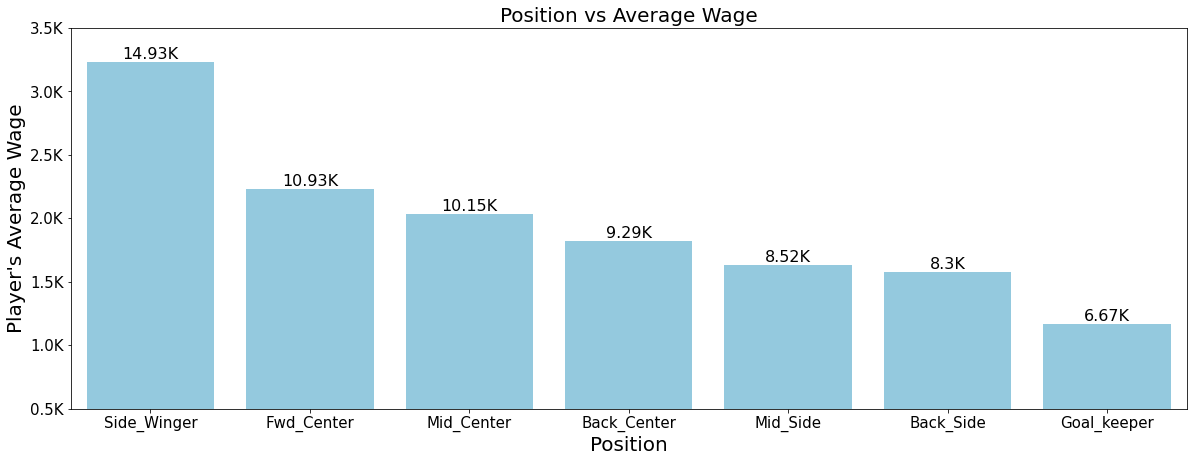

In [10]:
# make a copy and preprocess the data
pos_wage_df = df.copy()
pos_wage_df = pos_wage_df.groupby(['best_pos'])\
                         .mean()\
                         .reset_index()\
                         .sort_values\
                         ('wage_eur', ascending = False)[['best_pos','wage_eur']]
pos_wage_df['wage_eur'] = pos_wage_df['wage_eur']/(10**3)
pos_wage_df.reset_index(inplace = True, drop = True)

# Figure plotting
fig = plt.figure(figsize = (20,7))
ax = sns.barplot(x = 'best_pos', y = 'wage_eur', data = pos_wage_df, color='skyblue')
ax.set_yticklabels(labels = ['0.5K','1.0K','1.5K','2.0K','2.5K','3.0K','3.5K','4.0K','4.5K'])

# Set the preference of label
plt.xlabel('Position', size = 20)
plt.ylabel("Player's Average Wage", size = 20)
plt.title(f'Position vs Average Wage', size=20)    
plt.tick_params(axis = 'x', labelsize = 15)
plt.tick_params(axis = 'y', labelsize = 15)    
y_min = int(pos_wage_df['wage_eur'].min())-2
y_max = int(pos_wage_df['wage_eur'].max())+2
plt.ylim((y_min, y_max))
    
# Display the values on the graph
display(pos_wage_df)
for index, row in pos_wage_df.iterrows():
    ax.text(x=index, y=row.wage_eur, s=str(round(row.wage_eur,2))+'K', c='black', ha='center', va='bottom', fontsize=16)
plt.show()

## Prediction of the player's best position

In this section, I will start to build up the models that can help the soccer player to find out their best position based on their specific attributes. Firstly, I can take a look at what the Top 5 features are that contribute mostly to being well in each kind of position by employing univariate feature selection:

In [11]:
from sklearn.feature_selection import SelectKBest, f_regression

# Preprocess the data
feature_pos_df = df.copy()
feature_pos_df = feature_pos_df.drop(columns=['short_name', 'nationality','club', 'potential',\
                                              'value_eur', 'wage_eur', 'international_reputation','defending'])
positions = np.unique(feature_pos_df['best_pos'])
position_TOP5_features = []

# Iterate all the positions and figure out the most important 5 features by using SeleckKBest function
for pos in positions:
    pos_df = feature_pos_df[feature_pos_df['best_pos'] == pos]
    sub_X = pos_df.drop(columns=['best_pos','overall'])
    sub_y = pos_df['overall']
    cols = sub_X.columns
    
    # Build up the SelectKBest function
    my_KBest = SelectKBest(f_regression, k=5)
    my_KBest.fit(sub_X, sub_y)
    feature_mask = my_KBest.get_support()
    TOP5_features = sub_X.columns[feature_mask]
    position_TOP5_features.append((pos, TOP5_features))
    
# Print out the results
for item in position_TOP5_features:
    print(f'The top 5 features of being well in {item[0]} position are:')
    for i in item[1]:
        print(i)
    print('\n')

The top 5 features of being well in Back_Center position are:
movement_reactions
mentality_interceptions
defending_marking
defending_standing_tackle
defending_sliding_tackle


The top 5 features of being well in Back_Side position are:
passing
attacking_crossing
skill_ball_control
mentality_interceptions
defending_standing_tackle


The top 5 features of being well in Fwd_Center position are:
shooting
attacking_finishing
skill_ball_control
movement_reactions
mentality_positioning


The top 5 features of being well in Goal_keeper position are:
gk_diving
gk_reflexes
goalkeeping_diving
goalkeeping_positioning
goalkeeping_reflexes


The top 5 features of being well in Mid_Center position are:
passing
attacking_short_passing
skill_long_passing
skill_ball_control
movement_reactions


The top 5 features of being well in Mid_Side position are:
passing
dribbling
skill_dribbling
skill_ball_control
mentality_positioning


The top 5 features of being well in Side_Winger position are:
passing
dribbl

Based on what I observed before, I have around 60 features which are also too many. So, I decided to use PCA to reduce the dimensions to save run-time and also turn the dependent variables to independent variables.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Preprocess the data
pos_df = df.copy()
pos_df.drop(columns = ['short_name','nationality','club'], inplace = True)

# Extract the features and target
X = pos_df.iloc[:,:-1]
y = pos_df.iloc[:,-1]
model_list = []

# Split the remainder and test data set
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)

In [13]:
from sklearn.decomposition import PCA

# Use Standard Scaler to make sure all the features are in the same scale
scaler = StandardScaler()
scaler.fit(X_remainder)
X_remainder_scaled = scaler.transform(X_remainder)

# Check how many components should be included to make sure 90% of variance can be explained by PCA
total_feature = pos_df.shape[1]
my_pca = PCA(n_components=total_feature-1)
my_pca.fit(X_remainder_scaled)
explained_var = my_pca.explained_variance_ratio_.cumsum()
display(explained_var)
# n_components = 10 !!!!!!!!!!!!!!!!!!!!!!!!!

array([0.52673239, 0.64405298, 0.74836206, 0.79497064, 0.82635442,
       0.85117113, 0.86983181, 0.88471003, 0.89732755, 0.90660357,
       0.91403522, 0.9208547 , 0.92710948, 0.93224757, 0.93718296,
       0.94178107, 0.9461975 , 0.95054279, 0.95462367, 0.95826949,
       0.96178421, 0.96510705, 0.96837876, 0.97128626, 0.97383086,
       0.97631904, 0.97861427, 0.98081488, 0.98286684, 0.98471806,
       0.98647042, 0.9881344 , 0.98956092, 0.99081731, 0.99199996,
       0.99315772, 0.99423746, 0.99526247, 0.99600023, 0.99666067,
       0.99724873, 0.9977946 , 0.9983283 , 0.99880377, 0.99920272,
       0.99955841, 0.99966825, 0.99975654, 0.99982372, 0.99987316,
       0.99990996, 0.99994299, 0.99996514, 0.99998507, 0.99999817,
       1.        ])

Now, I will continue to create the models. I gonna create six models and find out the most predictive one. Besides that, I will use Pipeline to deal with the leakage between the estimators and apply the Grid Search CV to tune the hyperparameters:

In [14]:
from sklearn.neighbors import KNeighborsClassifier

# KNN model
if not os.path.exists('models/KNN_Classifier_best_pos.pkl'):
    
    # KNN Pipeline
    KNN_pipeline = Pipeline([('scaler', StandardScaler()),\
                             ('dim_reducer', PCA()),\
                             ('model', KNeighborsClassifier())])
    
    # KNN GridSearch Parameters
    KNN_param = {'scaler':[StandardScaler()],
                 'dim_reducer': [PCA(n_components=10)],
                 'model': [KNeighborsClassifier()],
                 'model__n_neighbors': list(range(10,75,5)),
                 'model__weights': ['uniform','distance'],
                 'model__algorithm': ['auto','kd_tree']}
    
    # Fit and Train the models
    GS_KNN = GridSearchCV(KNN_pipeline, param_grid=KNN_param, cv=5, n_jobs=-1, verbose=0)
    GS_KNN.fit(X_remainder, y_remainder)
    joblib.dump(GS_KNN, 'models/KNN_Classifier_best_pos.pkl')

# If the model is already saved in pkl file, just load it and use it directly
else:
    GS_KNN = joblib.load('models/KNN_Classifier_best_pos.pkl')
    
# Prediction    
y_pred = GS_KNN.predict(X_test)
# Score
score = GS_KNN.score(X_test, y_test)

# Append to list for further visualization
model_list.append(['KNN_Classifier', GS_KNN.best_params_, score, y_pred])

In [15]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree model
if not os.path.exists('models/DT_Classifier_best_pos.pkl'):

    # Decision Tree Pipeline
    DT_pipeline = Pipeline([('scaler', StandardScaler()),\
                             ('dim_reducer', PCA()),\
                             ('model', DecisionTreeClassifier())])
    
    # Decision Tree GridSearchCV
    DT_param = {'scaler':[StandardScaler()],
                'dim_reducer': [PCA(n_components=10)],
                'model': [DecisionTreeClassifier()],
                'model__max_depth': list(range(5,55,5)),
                'model__min_samples_leaf': list(range(1,11,2)),
                'model__criterion': ['gini','entropy']}
    
    # Fit and train the model
    GS_DT = GridSearchCV(DT_pipeline, param_grid=DT_param, cv=5, n_jobs=-1, verbose=0)
    GS_DT.fit(X_remainder, y_remainder)
    joblib.dump(GS_DT, 'models/DT_Classifier_best_pos.pkl')
    
else:
    GS_DT = joblib.load('models/DT_Classifier_best_pos.pkl')

# Predicition
y_pred = GS_DT.predict(X_test)
# Score
score = GS_DT.score(X_test, y_test)

# Add result to list
model_list.append(['Decision Tree Classifier', GS_DT.best_params_, score, y_pred])

In [16]:
from sklearn.svm import SVC

# SVC model
if not os.path.exists('models/SVC_Classifier_best_pos.pkl'):
    
    # SVC Pipeline
    SVC_pipeline = Pipeline([('scaler', StandardScaler()),\
                             ('dim_reducer', PCA()),\
                             ('model', SVC())])
    
    # SVC Parameters
    SVC_param = {'scaler':[StandardScaler()],
                 'dim_reducer': [PCA(n_components=10)],
                 'model': [SVC()],
                 'model__C': list(range(1,30,5)),
                 'model__kernel': ['linear','rbf','sigmoid']}
    
    # Fit and train the model
    GS_SVC = GridSearchCV(SVC_pipeline, param_grid=SVC_param, cv=5, n_jobs=-1, verbose=0)
    GS_SVC.fit(X_remainder, y_remainder)
    joblib.dump(GS_SVC, 'models/SVC_Classifier_best_pos.pkl')
    
else:
    GS_SVC = joblib.load('models/SVC_Classifier_best_pos.pkl')

# Prediction
y_pred = GS_SVC.predict(X_test)
# Score
score = GS_SVC.score(X_test, y_test)

# Append result
model_list.append(['SVC Classifier', GS_SVC.best_params_, score, y_pred])

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Random Foreset Model
if not os.path.exists('models/RF_Classifier_best_pos.pkl'):

    # Random Foreset Pipeline
    RF_pipeline = Pipeline([('scaler', StandardScaler()),\
                             ('dim_reducer', PCA()),\
                             ('model', RandomForestClassifier())])
    
    # Random Foreset Grid Search CV
    RF_param = {'scaler':[StandardScaler()],
                'dim_reducer': [PCA(n_components=10)],
                'model': [RandomForestClassifier()],
                'model__n_estimators': list(range(100,350,50)),
                'model__criterion': ['gini','entropy'],
                'model__max_depth': list(range(5,50,10))}

    # Fit and train model
    GS_RF = GridSearchCV(RF_pipeline, param_grid=RF_param, cv=5, n_jobs=-1, verbose=0)
    GS_RF.fit(X_remainder, y_remainder)
    joblib.dump(GS_RF, 'models/RF_Classifier_best_pos.pkl')
    
else:
    GS_RF = joblib.load('models/RF_Classifier_best_pos.pkl')

# Prediction    
y_pred = GS_RF.predict(X_test)
# Score
score = GS_RF.score(X_test, y_test)

# Append the result
model_list.append(['Random Forest Classifier', GS_RF.best_params_, score, y_pred])

In [18]:
from xgboost import XGBClassifier

# XGB Boosting model
if not os.path.exists('models/XGB_Classifier_best_pos.pkl'):
    
    # XGB Pipeline
    XGB_pipeline = Pipeline([('scaler', StandardScaler()),\
                             ('dim_reducer', PCA()),\
                             ('model', XGBClassifier())])
    
    # XGB GridSearch CV
    XGB_param = {'scaler':[StandardScaler()],
                'dim_reducer': [PCA(n_components=10)],
                'model': [XGBClassifier()],
                'model__n_estimators': list(range(100,300,50))}

    # Fit and train model
    GS_XGB = GridSearchCV(XGB_pipeline, param_grid=XGB_param, cv=5, n_jobs=-1, verbose=0)
    GS_XGB.fit(X_remainder, y_remainder)
    joblib.dump(GS_XGB, 'models/XGB_Classifier_best_pos.pkl')
    
else:
    GS_XGB = joblib.load('models/XGB_Classifier_best_pos.pkl')

# Prediction
y_pred = GS_XGB.predict(X_test)
# Score
score = GS_XGB.score(X_test, y_test)

# Append the result
model_list.append(['XG Boosting Classifier', GS_XGB.best_params_, score, y_pred])

In [19]:
# Scale the data into standard format for Neural Network
standard_scaler = StandardScaler()
standard_scaler.fit(X_remainder)

X_remainder = standard_scaler.transform(X_remainder)
X_test = standard_scaler.transform(X_test)

In [20]:
# Reduce the dimensions for Neural Network
my_pca = PCA(n_components=10)
my_pca.fit(X_remainder)
X_remainder_PCA = my_pca.transform(X_remainder)
X_test_PCA = my_pca.transform(X_test)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model

# Add the layers in the Neural Network
my_FNN = Sequential()
my_FNN.add(Dense(units=32,
                 activation='relu',
                 input_shape=(10,)))
my_FNN.add(Dropout(0.2))
my_FNN.add(BatchNormalization())
my_FNN.add(Dense(units=64,
                 activation='relu'))
my_FNN.add(Dropout(0.2))
my_FNN.add(BatchNormalization())
my_FNN.add(Dense(units=32,
                 activation='relu'))
my_FNN.add(Dropout(0.2))
my_FNN.add(BatchNormalization())
my_FNN.add(Dense(units=7,
                 activation='softmax'))

# Add compiler
sgd = SGD(lr=0.01, decay=0.0, momentum=0.0, nesterov=False, clipnorm=2.0)
my_FNN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

In [22]:
# Map the non-numeric data into numeric data
mapping = {'Mid_Center':0, 'Back_Center':1, 'Back_Side':2, 'Fwd_Center':3,\
           'Mid_Side':4, 'Goal_keeper':5, 'Side_Winger':6}
y_remainder_map = y_remainder.map(mapping)
y_test_map = y_test.map(mapping)

# Load or create the neural network
if not os.path.exists('models/FNN_Classifier_best_pos.h5'):
    EPOCHS = 5000
    BATCH_SIZE = 480
    
    # Fit and train the Neural network
    my_FNN.fit(
        X_remainder_PCA, y_remainder_map,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=0)
    
    # great way to save the model as a json/h5 file set 
    # https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    model_json = my_FNN.to_json()
    with open("models/FNN_Classifier_best_pos.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    my_FNN.save_weights('models/FNN_Classifier_best_pos.h5')
    print("Saved model to disk")
    
else:
    my_FNN.load_weights('models/FNN_Classifier_best_pos.h5')
    print("Loaded weights model from disk") 
    print("No need to train, model is fully trained")

Loaded weights model from disk
No need to train, model is fully trained


In [23]:
# Score
loss, score = my_FNN.evaluate(X_test_PCA, y_test_map)
# Prediction
y_pred = my_FNN.predict_classes(X_test_PCA)
# Append the result to list
model_list.append(['Neural Network', my_FNN, score, y_pred])

3656/3656 [==============================] - 0s 95us/step


When I finished training the models, I try to plot the accuracy score and see which model is the best:

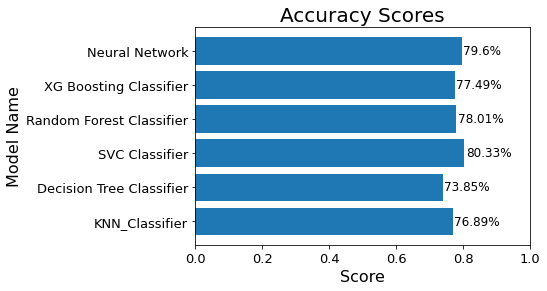

In [24]:
# Split the x and y value for graphing
model_list_array = np.array(model_list)
model_name = model_list_array[:,0]
model_score = model_list_array[:,2]

# Figure plotting
fig, ax = plt.subplots()
ind = np.arange(len(model_name))  # the x locations for the groups
ax.barh(ind, model_score)

# Set preference for ploting
plt.xticks(fontsize=13)
plt.yticks(ticks=ind, labels = model_name, fontsize=13)
plt.title('Accuracy Scores', fontsize=20)
plt.xlabel('Score',fontsize=16)
plt.ylabel('Model Name',fontsize=16)
plt.xlim(0,1)

# Display the values
for i, v in enumerate(model_score):
    ax.text(v+0.005, i-0.1, str(round(v*100,2))+'%', fontsize=12)
plt.show()

Based on my observations, I found that the Forward Neural Network and support vector machine classifier can give us the highest accuracy score which means that they are most predictive.

In order to have better insights into the classification, I use the confusion matrix to display the result.

<Figure size 432x288 with 0 Axes>

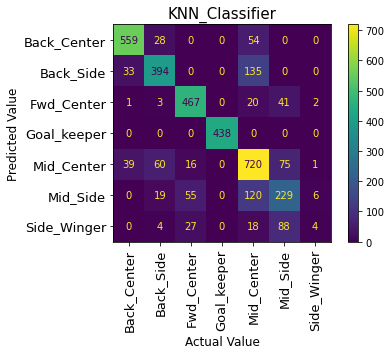

<Figure size 432x288 with 0 Axes>

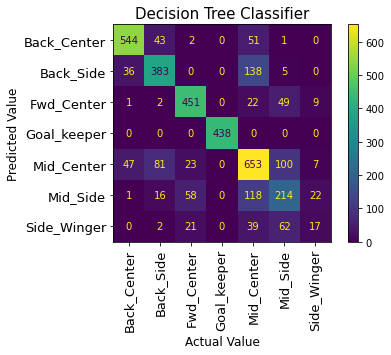

<Figure size 432x288 with 0 Axes>

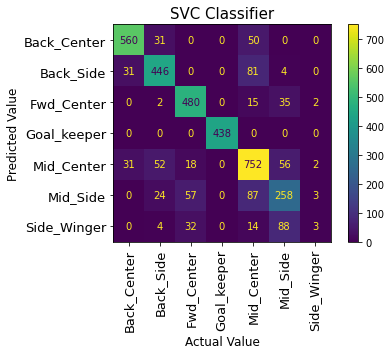

<Figure size 432x288 with 0 Axes>

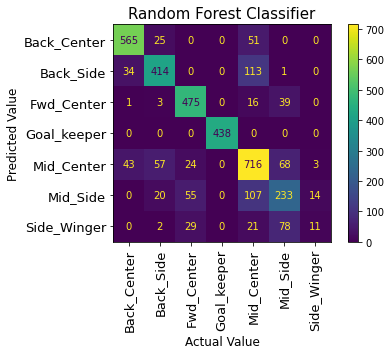

<Figure size 432x288 with 0 Axes>

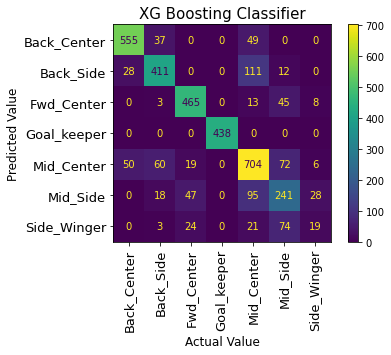

<Figure size 432x288 with 0 Axes>

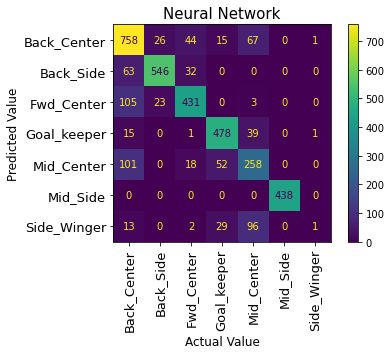

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

labels =  np.unique(y_test)

for i in range(len(model_list)):
    
    # Load the model name, model, score
    clf_name, clf, clf_score, y_pred = model_list[i]
    
    # confusion matrix for other models
    if i != len(model_list)-1:
        conf_matrix = confusion_matrix(y_test, y_pred)
    
    # confusion matrix for neural network
    else:
        conf_matrix = confusion_matrix(y_test_map, y_pred)
        
    # Plot the confusion matrix
    plt.figure()
    ConfusionMatrixDisplay(conf_matrix, display_labels=labels).plot(values_format='.3g',xticks_rotation = 'vertical')
    
    # Set preference for ploting
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.title(f'{clf_name}',fontsize=15)
    plt.xlabel('Actual Value', fontsize=12)
    plt.ylabel('Predicted Value', fontsize=12)
    
    plt.show()

The back-side players are more likely to be misclassified as the mid-center players. The prediction of side winger is pretty bad. The side wingers have a more comprehensive ability than other players. Thus, I think that this is the point why the side wingers have the larger player's value and can earn much more money than others. 

## Prediction of the player's overall rating

Now, I will continue to build up the regression models to figure out the relationship between the player's overall rating score and their specific attributes. Before starting to build up the models, I firstly want to explore what the Top 10 features are that contribute mostly to have higher overall rating:

In [26]:
# Copy the data frame
overall_df = df.copy()

# Preprocess the data
overall_df = overall_df.drop(columns=['short_name', 'nationality','club', 'best_pos', 'potential',\
                                      'value_eur', 'wage_eur', 'international_reputation','defending'])

# Split out the features and target
sub_X = overall_df.drop(columns=['overall'])
sub_y = overall_df['overall']

# Find out the most important 10 features
my_KBest = SelectKBest(f_regression, k=10)
my_KBest.fit(sub_X, sub_y)
feature_mask = my_KBest.get_support()

# Print the top 10 features
TOP10_features = sub_X.columns[feature_mask]
print(f'The top 10 features of having higher overall rating are:')
for item in TOP10_features:
    print(item)

The top 10 features of having higher overall rating are:
age
attacking_short_passing
skill_curve
skill_long_passing
skill_ball_control
movement_reactions
power_shot_power
power_long_shots
mentality_vision
mentality_composure


In [27]:
# make a copy
overall_df = df.copy()
# Drop non-numeric columns
overall_df.drop(columns = ['short_name','nationality','club', 'best_pos'], inplace = True)

# Split features and target
X = overall_df.drop(columns=['overall'])
y = overall_df['overall']
model_list = []

# Split the remainder and test data set
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)

In [28]:
# Standard Scaler applied
scaler = StandardScaler()
scaler.fit(X_remainder)
X_remainder_scaled = scaler.transform(X_remainder)

# Use PCA to reduce the dimensions
total_feature = overall_df.shape[1]
my_pca = PCA(n_components=total_feature-1)
my_pca.fit(X_remainder_scaled)
explained_var = my_pca.explained_variance_ratio_.cumsum()
display(explained_var)
# n_components = 10

array([0.53402318, 0.6511074 , 0.74666099, 0.79399036, 0.82592389,
       0.85084497, 0.86956204, 0.88470707, 0.8975522 , 0.90626424,
       0.91382156, 0.92075053, 0.92705613, 0.93228719, 0.93731166,
       0.94199241, 0.94642863, 0.95075143, 0.95489673, 0.95856361,
       0.96214223, 0.96550852, 0.96883944, 0.97170512, 0.97427656,
       0.97670209, 0.97903881, 0.98126315, 0.98332837, 0.98521319,
       0.98699123, 0.98868486, 0.99013503, 0.99140634, 0.99260437,
       0.99378195, 0.99487874, 0.99589923, 0.99657432, 0.9971865 ,
       0.99774547, 0.99828889, 0.99877315, 0.99917976, 0.99954582,
       0.99966002, 0.99975192, 0.99982035, 0.99987072, 0.99990825,
       0.99994191, 0.99996447, 0.99998478, 0.99999813, 1.        ])

Now, I will continue to create the models. I gonna create five regression models and find out the best one. Besides that, I will use Pipeline to deal with the leakage between the estimators and apply the Grid Search CV to tune the hyperparameters as what I did before:

In [29]:
from sklearn.neighbors import KNeighborsRegressor

# KNN regressor
if not os.path.exists('models/KNN_Regressor_overall.pkl'):
    
    # KNN Pipeline
    KNN_pipeline = Pipeline([('scaler', StandardScaler()),\
                             ('dim_reducer', PCA()),\
                             ('model', KNeighborsRegressor())])
    
    # KNN GridSearchCV Parameters
    KNN_param = {'scaler':[StandardScaler()],
                 'dim_reducer': [PCA(n_components=10)],
                 'model': [KNeighborsRegressor()],
                 'model__n_neighbors': list(range(10,75,5)),
                 'model__weights': ['uniform', 'distance'],
                 'model__algorithm': ['auto', 'kd_tree']}
    
    # Fit the model
    GS_KNN = GridSearchCV(KNN_pipeline, param_grid=KNN_param, cv=5, n_jobs=-1, verbose=0)
    GS_KNN.fit(X_remainder, y_remainder)
    joblib.dump(GS_KNN, 'models/KNN_Regressor_overall.pkl')

else:
    GS_KNN = joblib.load('models/KNN_Regressor_overall.pkl')

# Predicted result
y_pred = GS_KNN.predict(X_test)
# Score
score = GS_KNN.score(X_test, y_test)
# Append and store to a list
model_list.append(['KNN Regressor', GS_KNN.best_params_, score, y_pred])

In [30]:
from sklearn.tree import DecisionTreeRegressor

# Decision Tree Regressor
if not os.path.exists('models/DT_Regressor_overall.pkl'):

    # Decision Tree Pipeline
    DT_pipeline = Pipeline([('scaler', StandardScaler()),\
                             ('dim_reducer', PCA()),\
                             ('model', DecisionTreeRegressor())])

    # Decision Tree GridSearchCV
    DT_param = {'scaler':[StandardScaler()],
                'dim_reducer': [PCA(n_components=10)],
                'model': [DecisionTreeRegressor()],
                'model__criterion': ['mse','mae'],
                'model__max_depth': list(range(5,55,5)),
                'model__min_samples_leaf': list(range(1,11,2))}

    # Fit the model
    GS_DT = GridSearchCV(DT_pipeline, param_grid=DT_param, cv=5, n_jobs=-1, verbose=0)
    GS_DT.fit(X_remainder, y_remainder)
    joblib.dump(GS_DT, 'models/DT_Regressor_overall.pkl')

else:
    GS_DT = joblib.load('models/DT_Regressor_overall.pkl')

# Prediction
y_pred = GS_DT.predict(X_test)
# Score model
score = GS_DT.score(X_test, y_test)
# Store the result
model_list.append(['Decision Tree Regressor', GS_DT.best_params_, score, y_pred])

In [31]:
from sklearn.svm import SVR

# Support vector machine regressor
if not os.path.exists('models/SVR_Regressor_overall.pkl'):

    # SVR Pipeline
    SVR_pipeline = Pipeline([('scaler', StandardScaler()),\
                             ('dim_reducer', PCA()),\
                             ('model', SVR())])

    # SVR GridSearchCV
    SVR_param = {'scaler':[StandardScaler()],
                 'dim_reducer': [PCA(n_components=10)],
                 'model': [SVR()],
                 'model__C': list(range(1,30,5)),
                 'model__kernel': ['linear','rbf','sigmoid']}

    # Fit the model
    GS_SVR = GridSearchCV(SVR_pipeline, param_grid=SVR_param, cv=5, n_jobs=-1, verbose=0)
    GS_SVR.fit(X_remainder, y_remainder)
    joblib.dump(GS_SVR, 'models/SVR_Regressor_overall.pkl')

else:
    GS_SVR = joblib.load('models/SVR_Regressor_overall.pkl')

# Make prediction
y_pred = GS_SVR.predict(X_test)
# score the model
score = GS_SVR.score(X_test, y_test)

# append to a list
model_list.append(['SVR Regressor', GS_SVR.best_params_, score, y_pred])

In [32]:
from sklearn.ensemble import RandomForestRegressor

# Random Foreset Regressor
if not os.path.exists('models/RF_Regressor_overall.pkl'):

    # Pipeline
    RF_pipeline = Pipeline([('scaler', StandardScaler()),\
                             ('dim_reducer', PCA()),\
                             ('model', RandomForestRegressor())])
    
    # GridSearchCV
    RF_param = {'scaler':[StandardScaler()],
                'dim_reducer': [PCA(n_components=10)],
                'model': [RandomForestRegressor()],
                'model__n_estimators': list(range(100,350,50)),
                'model__max_depth': list(range(5,50,10))}

    # Train model
    GS_RF = GridSearchCV(RF_pipeline, param_grid=RF_param, cv=5, n_jobs=-1, verbose=0)
    GS_RF.fit(X_remainder, y_remainder)
    joblib.dump(GS_RF, 'models/RF_Regressor_overall.pkl')

else:
    GS_RF = joblib.load('models/RF_Regressor_overall.pkl')

# Predict and score
y_pred = GS_RF.predict(X_test)
score = GS_RF.score(X_test, y_test)
# Append the results
model_list.append(['Random Forest Regressor', GS_RF.best_params_, score, y_pred])

In [33]:
# Scale for Neural network
standard_scaler = StandardScaler()
standard_scaler.fit(X_remainder)

X_remainder = standard_scaler.transform(X_remainder)
X_test = standard_scaler.transform(X_test)

In [34]:
# PCA for Neural network
my_pca = PCA(n_components=10)
my_pca.fit(X_remainder)
X_remainder_PCA = my_pca.transform(X_remainder)
X_test_PCA = my_pca.transform(X_test)

In [35]:
from tensorflow.keras import backend as K
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Add layers to Neural network
my_FNN_Reg = Sequential()
my_FNN_Reg.add(Dense(units=32,
                     activation='relu',
                     input_shape=(10,)))
my_FNN_Reg.add(Dropout(0.2))
my_FNN_Reg.add(BatchNormalization())
my_FNN_Reg.add(Dense(units=64,
                     activation='relu'))
my_FNN_Reg.add(Dropout(0.2))
my_FNN_Reg.add(BatchNormalization())
my_FNN_Reg.add(Dense(units=32,
                     activation='relu'))
my_FNN_Reg.add(Dropout(0.2))
my_FNN_Reg.add(BatchNormalization())
my_FNN_Reg.add(Dense(units=1,
                     activation='linear'))

# Specify the compiler
sgd = SGD(lr=0.01, decay=0.0, momentum=0.0, nesterov=False, clipnorm=2.0)
my_FNN_Reg.compile(loss='mse',
                   optimizer=sgd,
                   metrics=[r2_keras])

In [36]:
if not os.path.exists('models/FNN_Regressor_overall.h5'):
    EPOCHS = 5000
    BATCH_SIZE = 480

    my_FNN_Reg.fit(X_remainder_PCA, y_remainder,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=0)
    
    # great way to save the model as a json/h5 file set 
    # https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    model_json = my_FNN_Reg.to_json()
    with open("models/FNN_Regressor_overall.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    my_FNN_Reg.save_weights("models/FNN_Regressor_overall.h5")
    print("Saved model to disk")
else:
    my_FNN_Reg.load_weights("models/FNN_Regressor_overall.h5")
    print("Loaded weights model from disk") 
    print("No need to train, model is fully trained")

Loaded weights model from disk
No need to train, model is fully trained


In [37]:
# Score and prediction
loss, score = my_FNN_Reg.evaluate(X_test_PCA, y_test)
y_pred = my_FNN_Reg.predict(X_test_PCA)
model_list.append(['Neural Network', my_FNN_Reg, score, y_pred])

3656/3656 [==============================] - 0s 68us/step


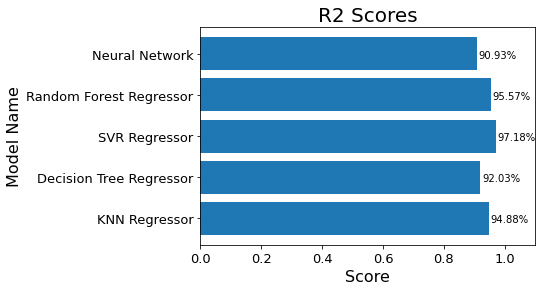

In [38]:
# Split out the x and y values
model_list_array = np.array(model_list)
model_name = model_list_array[:,0]
model_score = model_list_array[:,2]

# Figure plot
fig, ax = plt.subplots()
ind = np.arange(len(model_name))  # the x locations for the groups
ax.barh(ind, model_score)

# Set preference for ploting
plt.xticks(fontsize=13)
plt.yticks(ticks=ind, labels = model_name, fontsize=13)
plt.title('R2 Scores', fontsize=20)
plt.xlabel('Score',fontsize=16)
plt.ylabel('Model Name',fontsize=16)
plt.xlim(0,1.1)

# Display the values
for i, v in enumerate(model_score):
    ax.text(v+0.005, i-0.1, str(round(v*100,2))+'%', fontsize=10)
plt.show()

All the models have high r2 score, especially the support vector machine regressor.

## Pensonality description vs Position prediction:

Lastly, I will take in the text data as the features in the models and will try to extract the key pensonalities to behave well in each position.

In [39]:
# Preprocessing the data
df = original_df.copy()
df = df[['player_traits','player_positions']]

# Map the position
df['best_pos'] = df['player_positions'].str.split(',').str[0]
dict_pos={'ST':'Fwd_Center',
          'CF':'Fwd_Center',
          'LW':'Side_Winger',
          'RW':'Side_Winger',
          'LM':'Mid_Side',
          'RM':'Mid_Side',
          'CM':'Mid_Center',
          'CAM':'Mid_Center',
          'CDM':'Mid_Center',
          'CB':'Back_Center',
          'LB':'Back_Side',
          'RB':'Back_Side',
          'LWB':'Back_Side',
          'RWB':'Back_Side',
          'GK':'Goal_keeper'}
df['best_pos']=df['best_pos'].map(dict_pos)
df.drop(columns = ['player_positions'], inplace = True)
df.dropna(inplace = True)

# Split the text data and target
X = df['player_traits']
y = df['best_pos']

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import string

from nltk.corpus import stopwords
ENGLISH_STOP_WORDS = stopwords.words('english')

# Stemmer
stemmer = nltk.stem.PorterStemmer()

# Customize the tokenizer
def my_tokenizer(sentence):
    for punctuaion_mark in string.punctuation:
        sentence = sentence.replace(punctuaion_mark,'').lower()
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)
    return listofstemmed_words

# Split the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Count vectorization by using Tf-idf Vectorizer
count_vector = TfidfVectorizer(min_df=5,\
                               tokenizer=my_tokenizer,
                               ngram_range=(1,2))
count_vector.fit(X_train)
X_train = count_vector.transform(X_train)
X_test = count_vector.transform(X_test)

# Use the SVN Classifier to see the accuracy score of prediction
my_SVC = SVC()
my_SVC.fit(X_train, y_train)
score_train = my_SVC.score(X_train, y_train)
score_test = my_SVC.score(X_test, y_test)

# Print the scores
print(f'The score of train data is: {score_train}')
print(f'The score of test data is: {score_test}')

The score of train data is: 0.5731989424983477
The score of test data is: 0.5488771466314399


The result is around 55% in both the train and test data set, which means that the model doesn't behave pretty well. The reason may be that only one-third of players have the personality descriptions, so I don't have enough data to train and test the model.